
### Radial Velocity computation, with pre-calibrated files

In this file I will work with the precalibrated spectra data from EXPRES given to me by Lily Zhao.


In [158]:
# Import my .py code 
# Run this to reimport without having to restart the whole notebook
import calibration_functions
import importlib
importlib.reload(calibration_functions)
from calibration_functions import *

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

plt.rcParams['font.size'] = 16
plt.rc("font", family="serif")

from os import walk

In [8]:
# Loads real spectra from EXPREES (Lily) for star HD34411
REAL_SPECTRA_path = "/Users/jakobharteg/Data/34411_spectra/"
def get_all_spectra_filenames():
    SPEKTRA_filenames = next(walk(REAL_SPECTRA_path), (None, None, []))[2]  # [] if no file
    SPEKTRA_filenames = sorted(SPEKTRA_filenames)
    return SPEKTRA_filenames


# Load data from fits file for a given "real spectra file"
def load_spectra_fits(filename):
    path = REAL_SPECTRA_path  + "/" + filename
    hdul = fits.open(path)
    data = hdul[1].data.copy()
    hdul.close()
    return data

def get_spec_wavel(file, order):
    data_spec       = file['spectrum'][order]
    data_spec_err   = file['uncertainty'][order]
    data_wavel      = file['wavelength'][order]
    return data_spec, data_spec_err, data_wavel

### Look at the dates of the files

In [335]:
def load_spektra_date(filename):
    path = REAL_SPECTRA_path  + "/" + filename
    hdul = fits.open(path)
    header = hdul[0].header
    hdul.close()
    return header["DATE-OBS"]


def get_spectra_dates(filenames):
    dates = []
    for i in np.arange(len(filenames)):
        date = load_spektra_date(filenames[i])
        date = date[:date.index(" ")]
        year, month, date = date.split("-")
        year, month, date = int(year), int(month), int(date)
        dates.append((year, month, date))
    return dates


# There are often several observations per night
def get_spectra_filenames_without_duplicate_dates():
    all_files = get_all_spectra_filenames()
    all_dates = get_spectra_dates(all_files)
    files = [all_files[0]]
    dates = [all_dates[0]]
    for i in np.arange(1, len(all_dates)):
        if dates[-1] != all_dates[i]:
            dates.append(all_dates[i])
            files.append(all_files[i])
    return files

188


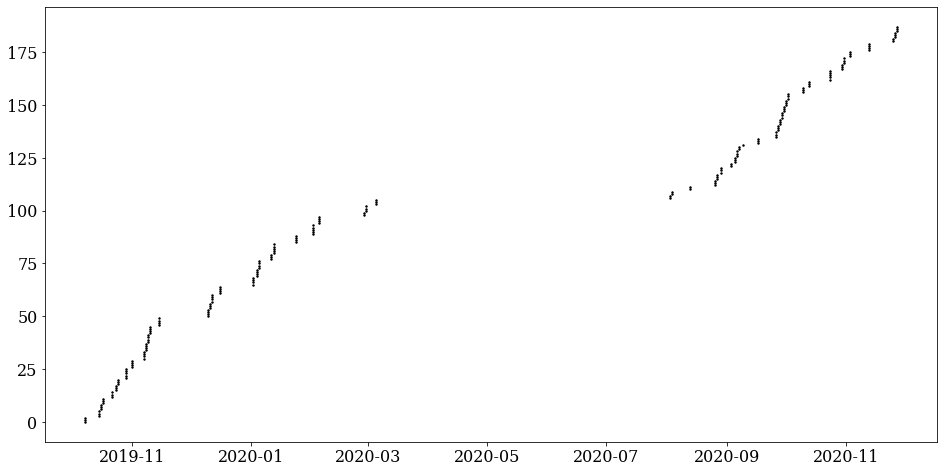

In [89]:
filenames = get_all_spectra_filenames()
dates = get_spectra_dates(filenames)
print(len(dates))

plt.figure(figsize=(16, 8))
for index, date in enumerate(dates):
    year, month, date = date
    d = datetime(year, month, date)
    plt.scatter(d, index, color="k", s=2)


# # Plot files for unique dates
# filenames = get_spectra_filenames_without_duplicate_dates()
# dates = get_spectra_dates(filenames)
# print(len(dates))

# for index, date in enumerate(dates):
#     year, month, date = date
#     d = datetime(year, month, date)
#     plt.scatter(d, index, color="red", s=5)

### First look at data

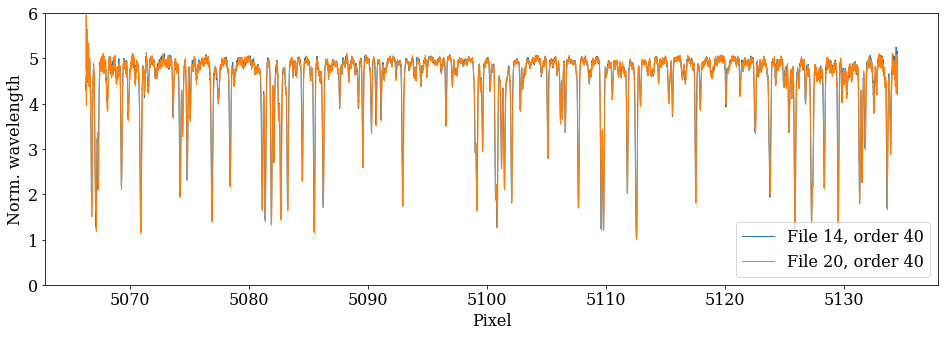

In [32]:
filenames = get_all_spectra_filenames()

def plot_file(file_index, date=None):
    SPECTRA_DATA = load_spectra_fits(filenames[file_index])
    order = 40
    data_spec       = -SPECTRA_DATA['spectrum'][order] # TODO it is more aligned when I add a minus in front, but don't know why??
    data_wavel      = SPECTRA_DATA['wavelength'][order]
    data_spec_norm = data_spec/np.nanmax(data_spec) # normalize intensity
    if date:
        # plt.plot(np.arange(len(data_spec_norm)), data_spec_norm, linewidth=1, label=f"File {file_index}, order {order}, {date}")
        plt.plot(data_wavel, data_spec_norm, linewidth=1, label=f"File {file_index}, order {order}, {date}")
    else:
        # plt.plot(np.arange(len(data_spec_norm)), data_spec_norm, linewidth=1, label=f"File {file_index}, order {order}")
        plt.plot(data_wavel, data_spec_norm, linewidth=1, label=f"File {file_index}, order {order}")

fig = plt.figure(figsize=(16,5))
plot_file(14)
plot_file(20)
# plt.xlim(5070, 5074)
# plt.xlim(5100, 5500)
plt.ylim(0, 6)
# plt.xlabel("Wavelength [Å]")
plt.xlabel("Pixel")
plt.ylabel("Norm. wavelength")
plt.legend(loc = "lower right")


### Animate change of peaks over all files



In [78]:
from tqdm import tqdm

dates = get_spectra_dates(filenames)
for i in tqdm(range(len(filenames))):
    fig = plt.figure(figsize=(16,5))
    plot_file(0, dates[0])
    plot_file(i, dates[i])
    # plt.xlim(5150, 5400)
    plt.xlim(5077, 5081)
    plt.ylim(1, 6)
    plt.xlabel("Wavelength [Å]")
    plt.ylabel("Intensity")
    plt.legend(loc = "lower right")
    plt.grid()
    plt.savefig(f"figures/shift_wavel_dates/file_{i}.png", dpi=100, facecolor="white")
    plt.close(fig) # don't show figure

100%|██████████| 188/188 [01:27<00:00,  2.14it/s]


### Minimisation without imuit

In [462]:
# New idea: interpolate to reduce to 1-dim (remove x-diffs)

def interp(x, y):
    return interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)

def compute_shift_between_files(filename1, filename2, order=40, plot=False):
    y1, y1_err, x1 = get_spec_wavel(load_spectra_fits(filename1), order)
    y2, y2_err, x2 = get_spec_wavel(load_spectra_fits(filename2), order)

    # TODO: multiply errors by sqrt(3)

    # Add shift for self test 
    # x2 = x2 + 0.25

    # Reduce range
    # s,f = 1000, 1250
    # x1 = x1[s:f]
    # y1 = y1[s:f]
    # y1_err = y1_err[s:f]
    # x2 = x2[s:f]
    # y2 = y2[s:f]
    # y2_err = y2_err[s:f]
    
    # Start when data is not nan
    x1 = x1[y1 > 0]
    y1_err = y1_err[y1 > 0]
    y1 = y1[y1 > 0]
    x2 = x2[y2 > 0]
    y2_err = y2_err[y2 > 0]
    y2 = y2[y2 > 0]

    # Normalize peak height
    y1 /= np.nanmax(y1)
    y2 /= np.nanmax(y2)
    # Normalize error
    y1_err /= np.nanmax(y1)
    y2_err /= np.nanmax(y2)

    # # Make plot for the first 100 points
    # a = x1[0:100]
    # b = y1[0:100]
    # plt.figure(figsize=(16,8))
    # plt.plot(a, b, "o")
    # f1 = interp1d(a, b, kind='cubic')
    # xnew = np.linspace(min(a), max(a), 100)
    # plt.plot(xnew, f1(xnew))

    # Plot all
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,7))
        ax1.plot(x1, y1, "o")
        ax1.plot(x2, y2, "o")

    # Interp first file
    f1 = interp1d(x1, y1, kind='cubic')
    f1_upper_err = interp1d(x1, y1 + y1_err, kind='cubic')
    f1_lower_err = interp1d(x1, y1 - y1_err, kind='cubic')

    # Interp for every shift
    # TODO: make two fold template shift (one broad, one more narrow around the center of the previous)
    shifts = np.linspace(-0.25, 0.25, 500)
    shifts = np.linspace(-0.05, 0.05, 500)
    shifts = np.linspace(-0.1, 0.1, 500)
    diffs = []
    chi2s = []
    for shift in shifts:
        
        # Interpolate template
        interp_x2 = x2 + shift
        f2 = interp1d(interp_x2, y2, kind='cubic')

        # Find common x-range
        xmin = max([min(x1), min(interp_x2)])
        xmax = min([max(x1), max(interp_x2)])
        xnewCommon = np.linspace(xmin, xmax, 1000) # TODO by decreasing this to 100 the curve get's very jumpy
        
        # Evaluate interpolation
        ynew1 = f1(xnewCommon)
        ynew2 = f2(xnewCommon)
        diff_mean = np.mean(abs(ynew1 - ynew2)) # TODO replace by chi2

        # Evalute error interpolation
        ynew1_upper_err = f1_upper_err(xnewCommon)
        ynew1_lower_err = f1_lower_err(xnewCommon)
        ynew1_errs = [np.abs(ynew1 - ynew1_upper_err), np.abs(ynew1 - ynew1_lower_err)] 
        ynew1_err = np.mean(ynew1_errs)

        # chi2 
        chi2 = np.sum(((ynew1 - ynew2) / ynew1_err)**2)
        
        diffs.append(diff_mean)
        chi2s.append(chi2)
        
        if plot:
            ax1.plot(xnewCommon, ynew2)
            # ax2.scatter(shift, diff_mean, color="k")
            ax2.scatter(shift, chi2, s=0.2, color="k")
            ax2.set_xlabel("Shift")
            ax2.set_ylabel("Chi2")
            # ax2.plot(xnewCommon, ynew1 - ynew2, linewidth=0.1)

    
    if plot:
        ax1.plot(xnewCommon, ynew1)

    # shift_min = shifts[np.argmin(diffs)] # diff-min
    shift_min = shifts[np.argmin(chi2s)] # chi2-min
    chi2_min = chi2s[np.argmin(chi2s)]

    # error_upper = shifts[chi2_min + 1]
    # error_lower = shifts[chi2_min - 1]

    return shift_min, chi2_min


(-0.001002004008016033, 25917.128465519716)

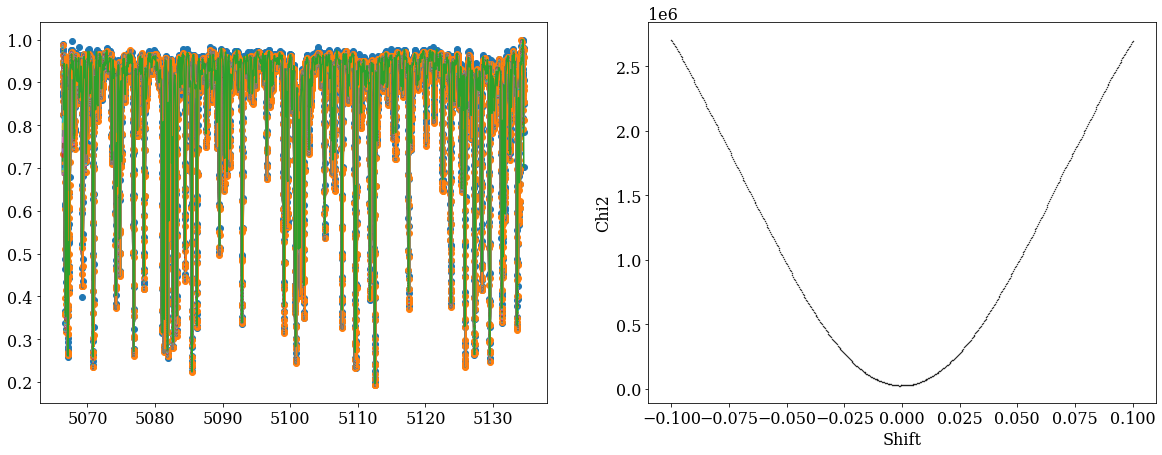

In [463]:
filenames = get_all_spectra_filenames()
compute_shift_between_files(filenames[0], filenames[1], plot=True)

### Minimisation with minuit

In [296]:
def interp(x, y):
    return interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)

def compute_shift_between_files_minuit(filename1, filename2, order=40, plot=False):
    y1, y1_err, x1 = get_spec_wavel(load_spectra_fits(filename1), order)
    y2, y2_err, x2 = get_spec_wavel(load_spectra_fits(filename2), order)

    # Add shift for self test 
    # x2 = x2 + 0.25

    # plt.figure(figsize=(16, 8))
    # plt.plot(x1, y1)
    # plt.plot(x2, y2)
    # plt.xlim(5090, 5092)

    # Reduce range
    # s,f = 1000, 1250
    # x1 = x1[s:f]
    # y1 = y1[s:f]
    # y1_err = y1_err[s:f]
    # x2 = x2[s:f]
    # y2 = y2[s:f]
    # y2_err = y2_err[s:f]
    
    # Start when data is not nan
    x1 = x1[y1 > 0]
    y1_err = y1_err[y1 > 0]
    y1 = y1[y1 > 0]
    x2 = x2[y2 > 0]
    y2_err = y2_err[y2 > 0]
    y2 = y2[y2 > 0]

    # Normalize peak height by mean instead of max height,
    # as that led to inconsistencies
    y1_mean = np.nanmean(y1)
    y2_mean = np.nanmean(y2)
    y1 /= y1_mean
    y2 /= y2_mean
    # Normalize error
    y1_err /= y1_mean
    y2_err /= y2_mean

    # Make plot for the first 100 points
    # a = x1[0:100]
    # b = y1[0:100]
    # plt.figure(figsize=(16,8))
    # plt.plot(a, b, "o")
    # f1 = interp1d(a, b, kind='cubic')
    # xnew = np.linspace(min(a), max(a), 100)
    # plt.plot(xnew, f1(xnew))

    # Plot all
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize=(20,7))
        ax1.plot(x1, y1)
        ax1.plot(x2, y2)

    # Interp first file
    f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")
    f1_upper_err = interp1d(x1, y1 + y1_err, kind='cubic', fill_value="extrapolate")
    f1_lower_err = interp1d(x1, y1 - y1_err, kind='cubic', fill_value="extrapolate")

    # ChiSquare fit model:
    def model_chi2(A):

        # Interpolate template
        interp_x2 = x2 + A
        f2 = interp1d(interp_x2, y2, kind='cubic', fill_value="extrapolate")

        # Find common x-range
        xmin = max([min(x1), min(interp_x2)])
        xmax = min([max(x1), max(interp_x2)])
        xnewCommon = np.linspace(xmin, xmax, 1000)
        
        # Evaluate interpolation
        ynew1 = f1(xnewCommon)
        ynew2 = f2(xnewCommon)

        # Evalute error interpolation
        ynew1_upper_err = f1_upper_err(xnewCommon)
        ynew1_lower_err = f1_lower_err(xnewCommon)
        ynew1_errs = [np.abs(ynew1 - ynew1_upper_err), np.abs(ynew1 - ynew1_lower_err)] 
        ynew1_err = np.mean(ynew1_errs)

        # Compute chi2
        chi2 = np.sum(((ynew1 - ynew2) / ynew1_err)**2)
        return chi2

    model_chi2.errordef = 1

    # First rough minimisation
    shifts = np.linspace(-0.1, 0.1, 500)
    shifts = np.linspace(-10, 10, 500)
    chi2s = []
    for shift in shifts:
        chi2s.append(model_chi2(shift))

    if plot:
        ax2.set_title("Init minimisation")
        ax2.plot(shifts, chi2s)
        ax2.set_xlabel("Wavelength shift")
        ax2.set_ylabel("Chi2")

    # get shift for minimum chi2
    shift_min = shifts[np.argmin(chi2s)]

    # Now we can use this as init value for iminuit and minimize again
    minuit = Minuit(model_chi2, A=shift_min)
    minuit.migrad()

    # Results
    valid = minuit.valid
    shift_min_final = minuit.values['A']
    shift_min_final_err = minuit.errors['A']

    return shift_min_final, shift_min_final_err, valid


def compute_shift_between_files_minuit_for_orders(filename1, filename2, orders=(37, 85), plot=False):
    shift_min_final, shift_min_final_err, valid = [], [], []
    order_range = np.arange(orders[0], orders[1])
    for order in order_range:
        a, b, c = compute_shift_between_files_minuit(filename1, filename2, plot=plot, order=order)
        shift_min_final.append(a)
        shift_min_final_err.append(b)
        valid.append(c)

    # Convert to numpy
    valid = np.asarray(valid)
    shift_min_final = np.asarray(shift_min_final)
    shift_min_final_err = np.asarray(shift_min_final_err)

    # compute weighted mean
    mean, err = weighted_mean(shift_min_final[valid], shift_min_final_err[valid])

    return mean, err, valid, shift_min_final, shift_min_final_err, order_range

-0.0012, ± 7.8e-05


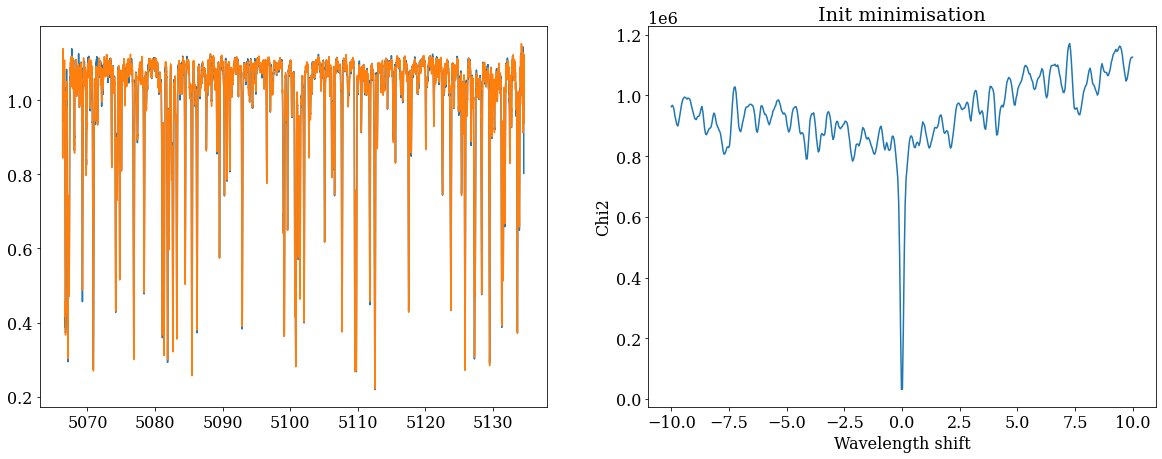

In [276]:
filenames = get_all_spectra_filenames()
r = compute_shift_between_files_minuit(filenames[0], filenames[1], order=40, plot=True)
print(f"{r[0]:.3}, ± {r[1]:.3}")

#### Try out for every order

In [283]:
filenames = get_all_spectra_filenames()
shift_mean, shift_mean_err, valid, shift_min_final, shift_min_final_err, orders = compute_shift_between_files_minuit_for_orders(filenames[0], filenames[1], plot=False)

Text(0.05, 0.93, 'mean shift = (-1.03e-06 ± 3e-07) Å')

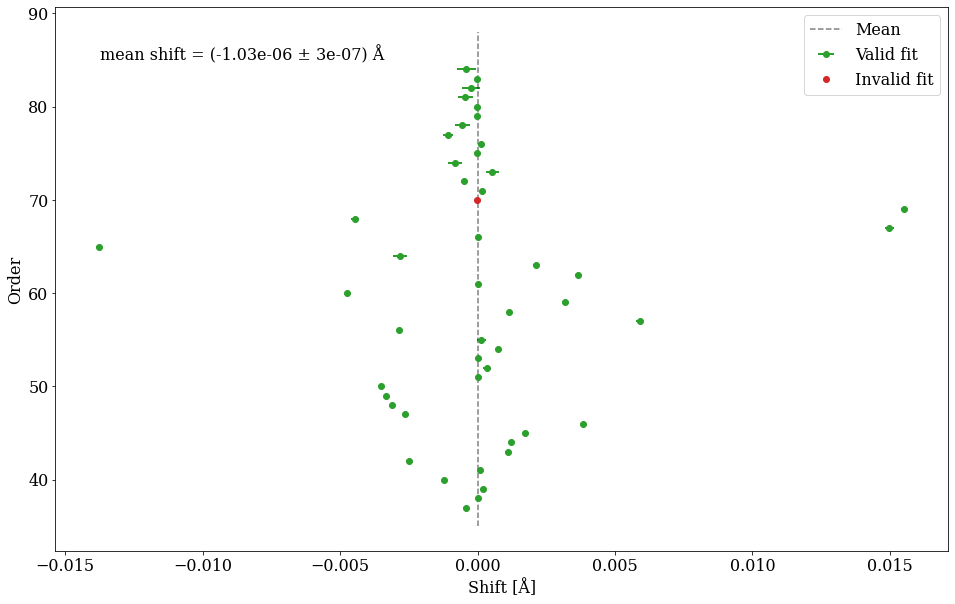

In [285]:
fig, ax = plt.subplots(figsize=(16, 10))

results_valid   = shift_min_final[valid], shift_min_final_err[valid], orders[valid]
results_invalid = shift_min_final[valid==False], shift_min_final_err[valid==False], orders[valid==False]

ax.errorbar(results_valid[0], results_valid[2], xerr=results_valid[1], fmt="o", linewidth=2, color = "C2", label="Valid fit")
ax.errorbar(results_invalid[0], results_invalid[2], fmt="o", linewidth=2, color = "C3", label="Invalid fit") # don't include errs for invalid, too big

# Plot mean and err
ax.vlines(shift_mean, 35, 88, linestyle="dashed", alpha=0.5, color="black", label="Mean")
# ax.axvspan(mean-err, mean+err, alpha=0.2) # too small to see anyway

ax.legend()
ax.set_xlabel("Shift [Å]")
ax.set_ylabel("Order")

ax.text(0.05, 0.93, f'mean shift = ({shift_mean:.3} ± {shift_mean_err:.1}) Å',
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes)

In [241]:
# Find out what those outer points are: 
a, b = [],[]
for stuff in zip(shift_min_final, shift_min_final_err, valid, orders):
    # if stuff[0] < -0.01:
    if stuff[2] != True:
        print(stuff)
        

(-8.149765943572871e-07, 3.156542461647585e-07, False, 53)
(-1.7691074108484366e-06, 6.439934426958472e-07, False, 55)
(-5.099530031005374e-07, 1.641754186831977e-06, False, 61)
(-1.12958081435363e-06, 4.0591921448271246e-07, False, 64)


### The matrix





In [90]:
# # filenames = get_all_spectra_filenames()[:10]
# filenames = get_spectra_filenames_without_duplicate_dates()[:10]
# size = len(filenames)
# diff_matrix, diff_matrix_err = np.empty((size,size)), np.empty((size,size))
# diff_matrix[:], diff_matrix_err[:] = np.nan, np.nan

# # for x in tqdm.tqdm(np.arange(size)):
# for x in tqdm.tqdm(np.arange(size)):
#     for y in np.arange(x, size):
#         shift_min_final, shift_min_final_err, valid = compute_shift_between_files_minuit(filenames[x], filenames[y])
#         if valid:
#             diff_matrix[x, y] = shift_min_final
#             diff_matrix_err[x, y] = shift_min_final_err

100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


In [319]:
# Try with the one for all orders
filenames = get_spectra_filenames_without_duplicate_dates()[:30]
size = len(filenames)
diff_matrix, diff_matrix_err, diff_matrix_valid = np.empty((size,size)), np.empty((size,size)), np.empty((size,size))
diff_matrix[:], diff_matrix_err[:], diff_matrix_valid[:] = np.nan, np.nan, np.nan

# for x in tqdm.tqdm(np.arange(size)):
for x in tqdm.tqdm(np.arange(size)):
    for y in np.arange(x, size):
        shift_mean, shift_mean_err, valid, *_ = compute_shift_between_files_minuit_for_orders(filenames[x], filenames[y], orders=(37, 85))

        # valid is a list of bools for each order, so extrac the ratio that converged
        valid_ratio = len(valid[valid])/len(valid)

        diff_matrix[x, y] = shift_mean
        diff_matrix_err[x, y] = shift_mean_err
        diff_matrix_valid[x, y] = valid_ratio


# Save
np.save("lily_data_results/diff", diff_matrix)
np.save("lily_data_results/diff_err", diff_matrix_err)
np.save("lily_data_results/diff_valid", diff_matrix_valid)

100%|██████████| 6/6 [01:17<00:00, 12.99s/it]


In [ ]:
# Load data again from file
diff_matrix = np.load("lily_data_results/diff.npy")
diff_matrix_err = np.load("lily_data_results/diff_err.npy")
diff_matrix_valid = np.load("lily_data_results/diff_valid.npy")

In [347]:
# Time to exectue matrix: one loop through takes 60 seconds for all orders
n = 30
minutes = n * (n + 1) / 2
print(f"{(minutes/60):.3} hours")

7.75 hours


Text(0.5, 1.0, 'Error')

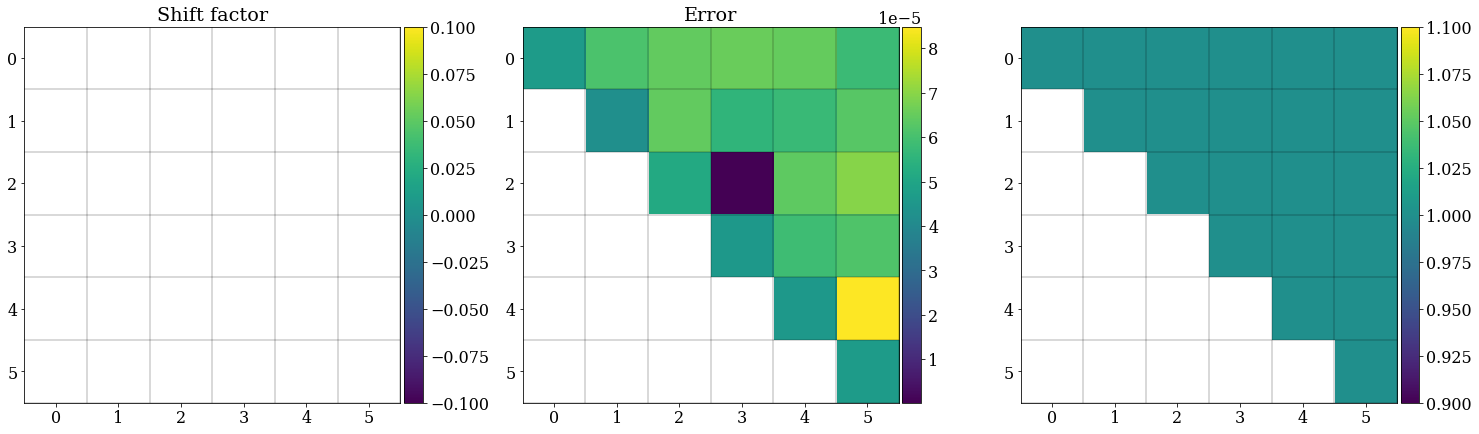

In [316]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(25,10))

def fix_grid_lines(ax, size):
    ax.hlines(y=np.arange(0, size)+0.5, xmin=np.full(size, 0)-0.5, xmax=np.full(size, size)-0.5, color="black", alpha=0.2)
    ax.vlines(x=np.arange(0, size)+0.5, ymin=np.full(size, 0)-0.5, ymax=np.full(size, size)-0.5, color="black", alpha=0.2)


# ======= PLOT 1 ============ Mean shifts
cs = ax1.imshow(-diff_matrix)
cax = make_axes_locatable(ax1).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax1, cax=cax)
fix_grid_lines(ax1, len(diff_matrix))

# ======= PLOT 2 ============ Errors
cs = ax2.imshow(diff_matrix_err)
cax = make_axes_locatable(ax2).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax2, cax=cax)
fix_grid_lines(ax2, len(diff_matrix_err))

# ======= PLOT 3 ============ Convergence ratio
cs = ax3.imshow(diff_matrix_valid)
cax = make_axes_locatable(ax3).append_axes('right', size='5%', pad=0.05) # to make color bar same height at plot, needed when making several subplots with each colorbar
cbar = fig.colorbar(cs, ax=ax3, cax=cax)
# cs.clim(0,1)
fix_grid_lines(ax3, len(diff_matrix_valid))


# Fix spacing between plots
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
fig.subplots_adjust(wspace=0.25)

ax1.set_title("Shift factor")
ax2.set_title("Error")


#### CROSS CORRELATION METHOD: 

In [372]:
# # CROSS CORRELATION METHOD: 

# y1, y1_err, x1 = get_spec_wavel(load_spectra_fits(filenames[0]), 40)
# y2, y2_err, x2 = get_spec_wavel(load_spectra_fits(filenames[5]), 40)

# corr = signal.correlate([x1, y1], [x2, y2])
# plt.matshow(corr)
